# Quantum Embedding of Ising configurations

## Imports and random seed

In [41]:
import os
import random
import numpy as np
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from math import ceil, log2

In [36]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)

## Importing the data

In [45]:
# Size of the images, the number of qubits is 2 * ceil(log2(size_image)) + 1   (Height, Width and spin channel)
image_size = 2
# Ising infinite lattice size critical temperature
statistical_control_parameter = 2.2692 

with open('./data/ising/L={}/T={:.4f}.bin'.format(image_size, statistical_control_parameter), 'rb') as f:
    X = np.frombuffer(buffer=f.read(), dtype=np.int8, offset=0).reshape(-1, image_size, image_size)

idx = np.random.randint(X.shape[0])
image = X[idx]

In [46]:
image

array([[ 1,  1],
       [-1, -1]], dtype=int8)

## NEQR Quantum encoding

In [88]:
side_qubits = ceil(log2(image_size))
image_qubits = 2 * side_qubits
total_qubits = image_qubits + 1

In [85]:
def binary_formatting(
    digit: int,
    n_bits: int,
    reverse: bool = False,
) -> str:
    r"""
    Args:
        digit (int): number whose binary representation we are computing
        n_bits (int): number of bits used in the binary representation (to handle left trailing zeros)
        reverse (bool): optionally return the binary representation of digit in reverse order (for qiskit convention)
    Returns:
        (str): binary representation of digit
    """

    binary = format(digit, '0{}b'.format(n_bits))

    if reverse:
        binary = binary[::-1]

    return binary

In [86]:
# Initialize the quantum circuit for the image 
# Pixel position
idx = QuantumRegister(image_qubits, 'idx')
# grayscale pixel intensity value
intensity = QuantumRegister(1,'intensity')
# classical register
cr = ClassicalRegister(image_qubits + 1, 'cr')

# create the quantum circuit for the image
qc_image = QuantumCircuit(intensity, idx, cr)

# set the total number of qubits
num_qubits = qc_image.num_qubits

qc_image.draw()

intensity: 
           
    idx_0: 
           
    idx_1: 
           
     cr: 3/

In [87]:
# Initialize the quantum circuit

# Optional: Add Identity gates to the intensity values
for i in range(intensity.size):
    qc_image.i(i)

# Add Hadamard gates to the pixel positions    
for i in range(1, idx.size + 1):
    qc_image.h(i)

# Separate with barrier so it is easy to read later.
qc_image.barrier()
qc_image.draw()

┌───┐ ░ 
intensity: ┤ I ├─░─
           ├───┤ ░ 
    idx_0: ┤ H ├─░─
           ├───┤ ░ 
    idx_1: ┤ H ├─░─
           └───┘ ░ 
     cr: 3/════════

In [67]:
for i in range(image_size):
    for j in range(image_size):

        if image[i, j] == 1:

            binarized_i = binary_formatting(digit=i, n_bits=side_qubits, reverse=False)
            binarized_j = binary_formatting(digit=j, n_bits=side_qubits, reverse=False)

            

            qc_image.x(qc_image.num_qubits-i)
            qc_image.x(qc_image.num_qubits-i)

            
        

CircuitError: 'Index 3 out of range for size 3.'

In [66]:
# Encode the first pixel, since its value is 0, we will apply ID gates here:
for idx in range(total_qubits):
    qc_image.i(idx)

qc_image.barrier()
qc_image.draw()

┌───┐ ░ ┌───┐ ░ 
intensity: ┤ I ├─░─┤ I ├─░─
           ├───┤ ░ ├───┤ ░ 
    idx_0: ┤ H ├─░─┤ I ├─░─
           ├───┤ ░ ├───┤ ░ 
    idx_1: ┤ H ├─░─┤ I ├─░─
           └───┘ ░ └───┘ ░ 
     cr: 3/════════════════

We will assign |0> to a -1 spin and |1> to a +1 spin.

In [60]:
# Encode the second pixel whose value is (01100100):
value01 = '01100100'

# Add the NOT gate to set the position at 01:
qc_image.x(qc_image.num_qubits-1)

# We'll reverse order the value so it is in the same order when measured.
for idx, px_value in enumerate(value01[::-1]):
    if(px_value=='1'):
        qc_image.ccx(num_qubits-1, num_qubits-2, idx)

# Reset the NOT gate
qc_image.x(num_qubits-1)

qc_image.barrier()
qc_image.draw()

CircuitError: 'duplicate qubit arguments'

In [31]:
# Encode the third pixel whose value is (11001000):
value10 = '11001000'

# Add the 0CNOT gates, where 0 is on X pixel:
qc_image.x(num_qubits-2)
for idx, px_value in enumerate(value10[::-1]):
    if(px_value=='1'):
        qc_image.ccx(num_qubits-1, num_qubits-2, idx)
qc_image.x(num_qubits-2)


qc_image.barrier()
qc_image.draw()

┌───┐ ░ ┌───┐ ░                           ░                     »
intensity_0: ┤ I ├─░─┤ I ├─░───────────────────────────░─────────────────────»
             ├───┤ ░ ├───┤ ░                           ░                     »
intensity_1: ┤ I ├─░─┤ I ├─░───────────────────────────░─────────────────────»
             ├───┤ ░ ├───┤ ░      ┌───┐                ░                     »
intensity_2: ┤ I ├─░─┤ I ├─░──────┤ X ├────────────────░─────────────────────»
             ├───┤ ░ ├───┤ ░      └─┬─┘                ░      ┌───┐          »
intensity_3: ┤ I ├─░─┤ I ├─░────────┼──────────────────░──────┤ X ├──────────»
             ├───┤ ░ ├───┤ ░        │                  ░      └─┬─┘          »
intensity_4: ┤ I ├─░─┤ I ├─░────────┼──────────────────░────────┼────────────»
             ├───┤ ░ ├───┤ ░        │  ┌───┐           ░        │            »
intensity_5: ┤ I ├─░─┤ I ├─░────────┼──┤ X ├───────────░────────┼────────────»
             ├───┤ ░ ├───┤ ░        │  └─┬─┘┌───┐      ░        │  ┌───┐     »
intensity_6: ┤ I ├─░─┤ I ├─░────────┼────┼──┤ X ├──────░────────┼──┤ X ├─────»
             ├───┤ ░ ├───┤ ░        │    │  └─┬─┘      ░        │  └─┬─┘┌───┐»
intensity_7: ┤ I ├─░─┤ I ├─░────────┼────┼────┼────────░────────┼────┼──┤ X ├»
             ├───┤ ░ ├───┤ ░        │    │    │        ░ ┌───┐  │    │  └─┬─┘»
      idx_0: ┤ H ├─░─┤ I ├─░────────■────■────■────────░─┤ X ├──■────■────■──»
             ├───┤ ░ ├───┤ ░ ┌───┐  │    │    │  ┌───┐ ░ └───┘  │    │    │  »
      idx_1: ┤ H ├─░─┤ I ├─░─┤ X ├──■────■────■──┤ X ├─░────────■────■────■──»
             └───┘ ░ └───┘ ░ └───┘               └───┘ ░                     »
      cr: 10/════════════════════════════════════════════════════════════════»
                                                                             »
«                   ░ 
«intensity_0: ──────░─
«                   ░ 
«intensity_1: ──────░─
«                   ░ 
«intensity_2: ──────░─
«                   ░ 
«intensity_3: ──────░─
«                   ░ 
«intensity_4: ──────░─
«                   ░ 
«intensity_5: ──────░─
«                   ░ 
«intensity_6: ──────░─
«                   ░ 
«intensity_7: ──────░─
«             ┌───┐ ░ 
«      idx_0: ┤ X ├─░─
«             └───┘ ░ 
«      idx_1: ──────░─
«                   ░ 
«      cr: 10/════════
«

In [32]:
# Encode the third pixel whose value is (10101010):
value11 = '11111111'

# Add the CCNOT gates:
for idx, px_value in enumerate(value11):
    if(px_value=='1'):
        qc_image.ccx(num_qubits-1,num_qubits-2, idx)

qc_image.barrier()
qc_image.measure(range(10),range(10))
qc_image.draw()

┌───┐ ░ ┌───┐ ░                           ░                     »
intensity_0: ┤ I ├─░─┤ I ├─░───────────────────────────░─────────────────────»
             ├───┤ ░ ├───┤ ░                           ░                     »
intensity_1: ┤ I ├─░─┤ I ├─░───────────────────────────░─────────────────────»
             ├───┤ ░ ├───┤ ░      ┌───┐                ░                     »
intensity_2: ┤ I ├─░─┤ I ├─░──────┤ X ├────────────────░─────────────────────»
             ├───┤ ░ ├───┤ ░      └─┬─┘                ░      ┌───┐          »
intensity_3: ┤ I ├─░─┤ I ├─░────────┼──────────────────░──────┤ X ├──────────»
             ├───┤ ░ ├───┤ ░        │                  ░      └─┬─┘          »
intensity_4: ┤ I ├─░─┤ I ├─░────────┼──────────────────░────────┼────────────»
             ├───┤ ░ ├───┤ ░        │  ┌───┐           ░        │            »
intensity_5: ┤ I ├─░─┤ I ├─░────────┼──┤ X ├───────────░────────┼────────────»
             ├───┤ ░ ├───┤ ░        │  └─┬─┘┌───┐      ░        │  ┌───┐     »
intensity_6: ┤ I ├─░─┤ I ├─░────────┼────┼──┤ X ├──────░────────┼──┤ X ├─────»
             ├───┤ ░ ├───┤ ░        │    │  └─┬─┘      ░        │  └─┬─┘┌───┐»
intensity_7: ┤ I ├─░─┤ I ├─░────────┼────┼────┼────────░────────┼────┼──┤ X ├»
             ├───┤ ░ ├───┤ ░        │    │    │        ░ ┌───┐  │    │  └─┬─┘»
      idx_0: ┤ H ├─░─┤ I ├─░────────■────■────■────────░─┤ X ├──■────■────■──»
             ├───┤ ░ ├───┤ ░ ┌───┐  │    │    │  ┌───┐ ░ └───┘  │    │    │  »
      idx_1: ┤ H ├─░─┤ I ├─░─┤ X ├──■────■────■──┤ X ├─░────────■────■────■──»
             └───┘ ░ └───┘ ░ └───┘               └───┘ ░                     »
      cr: 10/════════════════════════════════════════════════════════════════»
                                                                             »
«                   ░ ┌───┐                                    ░ ┌─┐         »
«intensity_0: ──────░─┤ X ├────────────────────────────────────░─┤M├─────────»
«                   ░ └─┬─┘┌───┐                               ░ └╥┘┌─┐      »
«intensity_1: ──────░───┼──┤ X ├───────────────────────────────░──╫─┤M├──────»
«                   ░   │  └─┬─┘┌───┐                          ░  ║ └╥┘┌─┐   »
«intensity_2: ──────░───┼────┼──┤ X ├──────────────────────────░──╫──╫─┤M├───»
«                   ░   │    │  └─┬─┘┌───┐                     ░  ║  ║ └╥┘┌─┐»
«intensity_3: ──────░───┼────┼────┼──┤ X ├─────────────────────░──╫──╫──╫─┤M├»
«                   ░   │    │    │  └─┬─┘┌───┐                ░  ║  ║  ║ └╥┘»
«intensity_4: ──────░───┼────┼────┼────┼──┤ X ├────────────────░──╫──╫──╫──╫─»
«                   ░   │    │    │    │  └─┬─┘┌───┐           ░  ║  ║  ║  ║ »
«intensity_5: ──────░───┼────┼────┼────┼────┼──┤ X ├───────────░──╫──╫──╫──╫─»
«                   ░   │    │    │    │    │  └─┬─┘┌───┐      ░  ║  ║  ║  ║ »
«intensity_6: ──────░───┼────┼────┼────┼────┼────┼──┤ X ├──────░──╫──╫──╫──╫─»
«                   ░   │    │    │    │    │    │  └─┬─┘┌───┐ ░  ║  ║  ║  ║ »
«intensity_7: ──────░───┼────┼────┼────┼────┼────┼────┼──┤ X ├─░──╫──╫──╫──╫─»
«             ┌───┐ ░   │    │    │    │    │    │    │  └─┬─┘ ░  ║  ║  ║  ║ »
«      idx_0: ┤ X ├─░───■────■────■────■────■────■────■────■───░──╫──╫──╫──╫─»
«             └───┘ ░   │    │    │    │    │    │    │    │   ░  ║  ║  ║  ║ »
«      idx_1: ──────░───■────■────■────■────■────■────■────■───░──╫──╫──╫──╫─»
«                   ░                                          ░  ║  ║  ║  ║ »
«      cr: 10/════════════════════════════════════════════════════╩══╩══╩══╩═»
«                                                                 0  1  2  3 »
«                               
«intensity_0: ──────────────────
«                               
«intensity_1: ──────────────────
«                               
«intensity_2: ──────────────────
«                               
«intensity_3: ──────────────────
«             ┌─┐               
«intensity_4: ┤M├───────────────
«             └╥┘┌─┐            
«intensity_5: ─╫

In [33]:
print('Circuit dimensions')
print('Circuit depth: ', qc_image.decompose().depth())
print('Circuit size: ', qc_image.decompose().size())

qc_image.decompose().count_ops()

Circuit dimensions
Circuit depth:  148
Circuit size:  244


OrderedDict([('cx', 84),
             ('t', 56),
             ('tdg', 42),
             ('h', 28),
             ('id', 18),
             ('measure', 10),
             ('barrier', 5),
             ('u3', 4),
             ('u2', 2)])

Encoded: 00 = 0
Encoded: 01 = 01100100
Encoded: 10 = 11001000
Encoded: 11 = 1
{'1111111111': 2029, '1011001000': 1996, '0101100100': 2078, '0000000000': 2089}


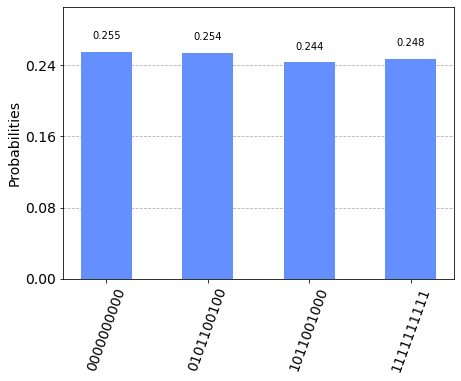

In [34]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=8192)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
print('Encoded: 00 = 0')
print('Encoded: 01 = 01100100')
print('Encoded: 10 = 11001000')
print('Encoded: 11 = 1')

print(counts_neqr)
plot_histogram(counts_neqr)